# Singapore GP

## A brief overview of Singapore GP and why it's particularly special:

We all know it as the OG night race, but many call Singapore one of the hardest tracks on the calendar. This prediction is particularly meaningful to me because I consider Singapore a home, and where else does a driver want to win most but their home race? 

This is a very high downforce circuit with lots of turns. The extreme heat (exponentially increased inside the car) coupled with the humidity serves as a physical and mental challenge for drivers. But I'm sure you knew that, and if you're reading this I'm sure you're thinking,'skip to the recipe already', so yes. Let's get to what really matters.

## Key technical improvements:
- Added 'position flexibility' variable for drivers by calculating average positions gained over the last five races. You could say this is a sort of 'overtaking capability' but it also indicates form for the drivers.
- Added Safety Car and Virtual Safety Car probabilities for the races.

I did notice that adding the new features didn't make much of a difference to the variance explanation. I think after 0.9, it tends to plateau and can only increase marginally. However, I did manage to reduce MAE (mean absolute error) to an even 2 seconds, which is extremely important given that our ranking factor is average lap time, not the total time taken to complete the race. When ranking by average lap time, the gaps between the positions become smaller, separated by as little as 0.1 second. So any decrease in MAE can help us get a more accurate ranking. 


## A note on using XGBoost

I spent some time trying out Regression using XGBoost now that my train data is sizeable (around 359 rows, still not enough to prevent overfitting but enough that with parameter tuning it can be controlled). You can check out the saved version of the notebook I used for that under the 'extras' folder. Although XGBoost yielded an amazing R² of 0.95 and an MAE under 1 second, it was really difficult to do feature weighting for values like Grid Position. 

In a track like Singapore where overtaking is difficult, your qualifying position tends to be important. It's difficult to have that much freedom with XGBoost. Plus the predictions I got from XGB seemed unrealistic (predicting Russel as P6 even though he got pole), so I have chosen to move forward with Ridge regression, since it's giving me the best R² and MAE combo so far.

Let me know if I'm wrong in my approach, but bear in mind that this is how I will see you: ☝🏽🤓 (lol joking. Suggestions are very welcome and needed)

# Prediction Flow

In [1]:
%pip install -q --upgrade numpy scikit-learn fastf1 keras xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import fastf1
import pandas as pd
fastf1.Cache.enable_cache("cache")

In [3]:
def get_weather_data(year,race,session):
    cur_session=fastf1.get_session(year,race,session)
    cur_session.load()
    weather_df=cur_session.weather_data
    weather_data={}
    weather_data["AirTemp"]=weather_df["AirTemp"].mean() # Average Air Temp in degrees Celsius
    weather_data["Humidity"]=weather_df["Humidity"].mean() # Average Humidity in % 
    weather_data["Pressure"]=weather_df["Pressure"].mean() # Average Air pressure in mbar
    weather_data["Rain"]=int(weather_df["Rainfall"].any()) # Check if there was any rainfall
    weather_data["WindSpeed"]=weather_df["WindSpeed"].mean() # Average Wind Speed in m/s
    weather_data["TrackTemp"]=weather_df["TrackTemp"].mean() # Average Track Temperature
    
    return weather_data

In [4]:
# We are not getting clean air race pace. We are getting the BEST pace from practice sessions. After talking to some people in the industry, I realised that
# the pace of the car in clean air might not be a very powerful predictive variable given that for most of the race the track WILL have other cars on it (shocker).

def get_best_race_pace(year, race):
    all_personal_bests = []
    
    for session in ["FP1", "FP2", "FP3"]:
        try:
            cur_session = fastf1.get_session(year, race, session)
            cur_session.load()
            laps = cur_session.laps
            
            laps = laps.drop(columns=['Time', 'DriverNumber', 'LapNumber', 'Stint',
            'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
            'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
            'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
            'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
            'LapStartDate', 'Position', 'DeletedReason',
            'FastF1Generated', 'IsAccurate'])
            # Note that while we are dropping DriverNumber, the 'Driver' column remaining contains abbreviations of the drivers for future mapping.

            laps = laps[(laps['Deleted']==False) & (laps.LapTime.notnull())]
            laps = laps.drop(columns=['Deleted','TrackStatus'])

            # Find Personal Best for this session
            personalbest = laps[laps['IsPersonalBest']==True].copy()
            if not personalbest.empty:
                personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
                personalbest = personalbest.drop(columns=['LapTime'])
                personalbest['Session'] = session  # Track which session
                all_personal_bests.append(personalbest)
                
        except Exception as e:
            print(f"Skipping {session} for {year} {race}: {e}")
            continue
    
    # Combine all sessions
    if all_personal_bests:
        
        combined_bests = pd.concat(all_personal_bests, ignore_index=True)
        
        # Find min lap time per driver across all sessions
        personalbest_map = combined_bests.loc[combined_bests.groupby('Driver')['LapTime (s)'].idxmin()]
        personalbest_map = personalbest_map.reset_index(drop=True)
        personalbest_map
        
        return personalbest_map
    else:
        return pd.DataFrame()  # Empty if no data found

In [5]:
"""
track_downforce_mapping = {
    'Monaco': 'Very High DF',
    'Singapore': 'Very High DF',
    'Canada': 'High DF',
    'Silverstone': 'High DF',
    'Imola': 'High DF',
    'Hungary': 'Medium DF',
    'Australia': 'Medium DF',
    'Bahrain': 'Medium DF',
    'Austria': 'Medium DF',
    'Netherlands': 'Medium DF',
    'Spain': 'Low DF',
    'United States': 'Low DF',
    'Japan': 'Low DF',
    'Saudi Arabia': 'Low DF',
    'Baku': 'Very Low DF',
    'Belgium': 'Very Low DF',
    'Monza': 'Very Low DF',
    'Miami': 'Very Low DF',
}

Numerical mapping:
downforce_numeric_mapping = {
    'Monaco': 5,
    'Singapore': 5,
    'Canada': 4,
    'Silverstone': 4,
    'Imola': 4,
    'Hungary': 3,
    'Australia': 3,
    'Bahrain': 3,
    'Austria': 3,
    'Netherlands': 3,
    'Spain': 2,
    'United States': 2,
    'Japan': 2,
    'Saudi Arabia': 2,
    'Baku': 1,
    'Belgium': 1,
    'Monza': 1,
    'Miami': 1,
}
"""

"\ntrack_downforce_mapping = {\n    'Monaco': 'Very High DF',\n    'Singapore': 'Very High DF',\n    'Canada': 'High DF',\n    'Silverstone': 'High DF',\n    'Imola': 'High DF',\n    'Hungary': 'Medium DF',\n    'Australia': 'Medium DF',\n    'Bahrain': 'Medium DF',\n    'Austria': 'Medium DF',\n    'Netherlands': 'Medium DF',\n    'Spain': 'Low DF',\n    'Japan': 'Low DF',\n    'Saudi Arabia': 'Low DF',\n    'Baku': 'Very Low DF',\n    'Belgium': 'Very Low DF',\n    'Monza': 'Very Low DF',\n    'Miami': 'Very Low DF',\n}\n\nNumerical mapping:\ndownforce_numeric_mapping = {\n    'Monaco': 5,\n    'Singapore': 5,\n    'Canada': 4,\n    'Silverstone': 4,\n    'Imola': 4,\n    'Hungary': 3,\n    'Australia': 3,\n    'Bahrain': 3,\n    'Austria': 3,\n    'Netherlands': 3,\n    'Spain': 2,\n    'Japan': 2,\n    'Saudi Arabia': 2,\n    'Baku': 1,\n    'Belgium': 1,\n    'Monza': 1,\n    'Miami': 1,\n}\n"

In [6]:
# Build Model Train Data
# To be used for normalisation
from sklearn.preprocessing import StandardScaler
import logging

logging.getLogger('fastf1').setLevel(logging.ERROR) # Truncate annoying console logs

train_sessions={2024:['Singapore'],2025:['Australia','China','Japan','Bahrain','Saudi Arabia','Miami','Imola','Monaco','Spain','Canada','Austria','Silverstone','Belgium','Hungary','Netherlands','Monza','Baku']}
train_df=pd.DataFrame()
y=pd.DataFrame()

for year in train_sessions:
    for race in train_sessions[year]:
        cur_session=fastf1.get_session(year,race,'R') # Get race results for all the races in the list
        cur_session.load()
        print(f"--------------------------------------------------\nLoaded Data for {year} {race}\n--------------------------------------------------")
        cur_results=cur_session.results
        
        #-----------------DROP UNNECESSARY COLUMNS-----------------
        cur_results = cur_results.reset_index(drop=True)
        cur_results=cur_results.drop(columns=['DriverNumber', 'BroadcastName', 'DriverId', 'TeamName',
            'TeamColor', 'FirstName', 'LastName', 'FullName',
            'HeadshotUrl', 'CountryCode', 'Position', 'ClassifiedPosition',
            'Q1', 'Q2', 'Q3', 'Status', 'Points'])
        #-----------------------------------------------------------
        
        cur_results.rename(columns={'Abbreviation':'Driver'},inplace=True)
        
        #------------------CALCULATE TOTAL RACETIME------------
        # Get winner's time in seconds
        cur_results.reset_index(drop=True,inplace=True)
        winner_time_seconds = cur_results.iloc[0]['Time'].total_seconds()

        cur_results['Time (s)'] = cur_results['Time'].dt.total_seconds()
        cur_results.loc[1:, 'Time (s)'] = winner_time_seconds + cur_results.loc[1:, 'Time (s)']

        #Winner
        cur_results.loc[0, 'Time (s)'] = winner_time_seconds

        # Deal w Null values
        cur_results['Time (s)'] = cur_results['Time (s)'].fillna(winner_time_seconds + 300)  # +5 minutes penalty
        #-------------------------------------------------------------
        
        
        #----------CALCULATE TOTAL LAP TIME BY SECTOR AVERAGE---------
        cur_laps = cur_session.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
        cur_laps.dropna(inplace=True)

        # convert lap and sector times to seconds
        for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
            cur_laps[f"{col} (s)"] = cur_laps[col].dt.total_seconds()

        # aggregate sector times by driver
        sector_times = cur_laps.groupby("Driver").agg({
            "Sector1Time (s)": "mean",
            "Sector2Time (s)": "mean",
            "Sector3Time (s)": "mean"
        }).reset_index()

        sector_times["TotalSectorTime (s)"] = (
            sector_times["Sector1Time (s)"] +
            sector_times["Sector2Time (s)"] +
            sector_times["Sector3Time (s)"]
        )
        
        cur_results =  cur_results.merge(sector_times[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
        
        y = pd.concat([y,cur_laps.groupby("Driver")["LapTime (s)"].mean().reindex(cur_results["Driver"])])
        #-------------------------------------------------------------
        
        
        #----------------------FEATURE ENGINEERING--------------------
        cur_results['Grid_Gap_to_Pole'] = cur_results['GridPosition'] - cur_results['GridPosition'].min()
        
        # Calculate average qualifying position per team and subtract the drivers' quali positions from the mean of their combined grid positions.
        cur_results['Quali_vs_Teammate'] = cur_results.groupby('TeamId')['GridPosition'].transform(lambda x: x - x.mean())

        cur_results['Race'] = race
        cur_results['Year'] = year
        #-------------------------------------------------------------
        
        
        #----------------------GET BEST RACE PACE----------------------
        # Get best track race pace across FP1, FP2 and FP3
        best_race_pace=get_best_race_pace(year,race)
        print("Got Best Race Pace") # Debug
        best_race_pace
        
        best_race_pace.drop(columns=['IsPersonalBest','Session'],inplace=True)
        pace_mapping=best_race_pace.set_index('Driver')['LapTime (s)']
        
        cur_results['Best_Pace_seconds'] = cur_results['Driver'].map(pace_mapping)
        #--------------------------------------------------------------
        
        
        #--------------------MORE FEATURE ENGINEERING------------------
        cur_results['Practice_Gap_to_Fastest'] = cur_results['Best_Pace_seconds'] - cur_results['Best_Pace_seconds'].min()

        cur_results['Practice_vs_Quali_Rank'] = cur_results['Best_Pace_seconds'].rank() - cur_results['GridPosition']

        cur_results['Quali_vs_Teammate'] = cur_results['Quali_vs_Teammate'].fillna(0)
        #--------------------------------------------------------------

        #------------------GET RACE DAY WEATHER DATA--------------------
        weather_data=get_weather_data(year,race,'R')
        cur_results = cur_results.assign(**weather_data)
        #---------------------------------------------------------------
        
        #---------------------------IS IT SINGAPORE?-------------------------
        if race!='Singapore':
            cur_results['Is_Singapore']=0
        else:
            cur_results['Is_Singapore']=1
        #---------------------------------------------------------------
        
        #-----------------------MAP DOWNFORCE LEVELS & SAFETY CAR PROBABILITIES---------------------
        downforce_map={
            'Monaco': 5,
            'Canada': 4,
            'Silverstone': 4,
            'Imola': 4,
            'Hungary': 3,
            'Australia': 3,
            'Bahrain': 3,
            'Austria': 3,
            'Netherlands': 3,
            'Spain': 2,
            'Japan': 2,
            'Saudi Arabia': 2,
            'Baku': 1,
            'Belgium': 1,
            'Miami': 1,
            'Monza': 1,
            'Singapore': 5,
            'China': 3
        }
        cur_results['Downforce_Level'] = cur_results['Race'].map(downforce_map)
        
        safety_car_map={
            'Monaco': 43,
            'Canada': 83,
            'Silverstone': 88,
            'Imola': 75,
            'Hungary': 25,
            'Australia': 50,
            'Bahrain': 63,
            'Austria': 38,
            'Netherlands': 50,
            'Spain': 38,
            'Japan': 67,
            'Saudi Arabia': 100,
            'Baku': 57,
            'Belgium': 63,
            'Miami': 67,
            'Monza': 50,
            'Singapore': 100,
            'China': 75
        }
        cur_results['Safety_Car_Prob'] = cur_results['Race'].map(safety_car_map)
        
        virtual_safety_car_map={
            'Monaco': 29,
            'Canada': 50,
            'Silverstone': 13,
            'Imola': 25,
            'Hungary': 25,
            'Australia': 67,
            'Bahrain': 50,
            'Austria': 50,
            'Netherlands': 50,
            'Spain': 25,
            'Japan': 50,
            'Saudi Arabia': 50,
            'Baku': 43,
            'Belgium': 0,
            'Miami': 67,
            'Monza': 38,
            'Singapore': 33,
            'China': 75
        }
        cur_results['VSC_Prob'] = cur_results['Race'].map(virtual_safety_car_map)
        
        #-----------------------------------------------------------------------------------------------
        
        #--------------- MAP POSITION GAINS/LOSSES ------------------------
        # Results taken after running script pos_flexibility_calculation.py
        
        flex_map = {
            'PIA': 2.0, 
            'NOR': 3.0, 
            'VER': 0.0, 
            'TSU': 0.8, 
            'HAD': 1.0, 
            'LAW': 0.0, 
            'ALO': 2.2, 
            'STR': -1.6, 
            'OCO': -2.2, 
            'BEA': -1.6, 
            'RUS': -1.2, 
            'ANT': 0.0, 
            'GAS': -0.2, 
            'COL': 1.2, 
            'HAM': -1.2, 
            'LEC': 3.2, 
            'ALB': -5.2, 
            'SAI': 1.0, 
            'BOR': -0.2, 
            'HUL': -0.6
        }
        cur_results['Position_Flexibility'] = cur_results['Driver'].map(flex_map)
        train_df = pd.concat([train_df, cur_results], ignore_index=True)      
        
        
 

--------------------------------------------------
Loaded Data for 2024 Singapore
--------------------------------------------------
Got Best Race Pace
--------------------------------------------------
Loaded Data for 2025 Australia
--------------------------------------------------
Got Best Race Pace
--------------------------------------------------
Loaded Data for 2025 China
--------------------------------------------------
Skipping FP2 for 2025 China: Session type 'FP2' does not exist for this event
Skipping FP3 for 2025 China: Session type 'FP3' does not exist for this event
Got Best Race Pace
--------------------------------------------------
Loaded Data for 2025 Japan
--------------------------------------------------
Got Best Race Pace
--------------------------------------------------
Loaded Data for 2025 Bahrain
--------------------------------------------------
Got Best Race Pace
--------------------------------------------------
Loaded Data for 2025 Saudi Arabia
---------

In [7]:
train_df

,Driver,TeamId,GridPosition,Time,Laps,Time (s),TotalSectorTime (s),Grid_Gap_to_Pole,Quali_vs_Teammate,Race,...,Humidity,Pressure,Rain,WindSpeed,TrackTemp,Is_Singapore,Downforce_Level,Safety_Car_Prob,VSC_Prob,Position_Flexibility
0,NOR,mclaren,1.0,0 days 01:40:52.571000,62.0,6052.571,97.576180,0.0,-2.0,Singapore,...,74.650000,1008.024375,0,0.955000,36.445625,1,5,100,33,3.0
1,VER,red_bull,2.0,0 days 00:00:20.945000,62.0,6073.516,97.903328,1.0,-5.5,Singapore,...,74.650000,1008.024375,0,0.955000,36.445625,1,5,100,33,0.0
2,PIA,mclaren,5.0,0 days 00:00:41.823000,62.0,6094.394,98.182393,4.0,2.0,Singapore,...,74.650000,1008.024375,0,0.955000,36.445625,1,5,100,33,2.0
3,RUS,mercedes,4.0,0 days 00:01:01.040000,62.0,6113.611,98.521131,3.0,0.5,Singapore,...,74.650000,1008.024375,0,0.955000,36.445625,1,5,100,33,-1.2
4,LEC,ferrari,9.0,0 days 00:01:02.430000,62.0,6115.001,98.490344,8.0,-0.5,Singapore,...,74.650000,1008.024375,0,0.955000,36.445625,1,5,100,33,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,HUL,sauber,17.0,0 days 00:01:20.237000,51.0,5686.645,107.190745,16.0,2.0,Baku,...,59.833333,1021.116026,0,1.507051,26.107051,0,1,57,43,-0.6
355,STR,aston_martin,14.0,0 days 00:01:36.392000,51.0,5702.800,107.550191,13.0,1.5,Baku,...,59.833333,1021.116026,0,1.507051,26.107051,0,1,57,43,-1.6
356,GAS,alpine,18.0,0 days 00:00:03.865000,50.0,5610.273,107.870717,17.0,1.0,Baku,...,59.833333,1021.116026,0,1.507051,26.107051,0,1,57,43,-0.2
357,COL,alpine,16.0,0 days 00:00:06.325000,50.0,5612.733,107.929087,15.0,-1.0,Baku,...,59.833333,1021.116026,0,1.507051,26.107051,0,1,57,43,1.2


In [8]:
train_df.columns

Index(['Driver', 'TeamId', 'GridPosition', 'Time', 'Laps', 'Time (s)',
       'TotalSectorTime (s)', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Race',
       'Year', 'Best_Pace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Humidity', 'Pressure', 'Rain',
       'WindSpeed', 'TrackTemp', 'Is_Singapore', 'Downforce_Level',
       'Safety_Car_Prob', 'VSC_Prob', 'Position_Flexibility'],
      dtype='object')

In [9]:
#Drop Time, Laps, Time (s)

train_df.drop(columns=['Time', 'Laps', 'Time (s)'],inplace=True)
train_df

,Driver,TeamId,GridPosition,TotalSectorTime (s),Grid_Gap_to_Pole,Quali_vs_Teammate,Race,Year,Best_Pace_seconds,Practice_Gap_to_Fastest,...,Humidity,Pressure,Rain,WindSpeed,TrackTemp,Is_Singapore,Downforce_Level,Safety_Car_Prob,VSC_Prob,Position_Flexibility
0,NOR,mclaren,1.0,97.576180,0.0,-2.0,Singapore,2024,89.646,0.000,...,74.650000,1008.024375,0,0.955000,36.445625,1,5,100,33,3.0
1,VER,red_bull,2.0,97.903328,1.0,-5.5,Singapore,2024,90.540,0.894,...,74.650000,1008.024375,0,0.955000,36.445625,1,5,100,33,0.0
2,PIA,mclaren,5.0,98.182393,4.0,2.0,Singapore,2024,90.431,0.785,...,74.650000,1008.024375,0,0.955000,36.445625,1,5,100,33,2.0
3,RUS,mercedes,4.0,98.521131,3.0,0.5,Singapore,2024,90.125,0.479,...,74.650000,1008.024375,0,0.955000,36.445625,1,5,100,33,-1.2
4,LEC,ferrari,9.0,98.490344,8.0,-0.5,Singapore,2024,90.559,0.913,...,74.650000,1008.024375,0,0.955000,36.445625,1,5,100,33,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,HUL,sauber,17.0,107.190745,16.0,2.0,Baku,2025,102.428,1.205,...,59.833333,1021.116026,0,1.507051,26.107051,0,1,57,43,-0.6
355,STR,aston_martin,14.0,107.550191,13.0,1.5,Baku,2025,102.771,1.548,...,59.833333,1021.116026,0,1.507051,26.107051,0,1,57,43,-1.6
356,GAS,alpine,18.0,107.870717,17.0,1.0,Baku,2025,102.674,1.451,...,59.833333,1021.116026,0,1.507051,26.107051,0,1,57,43,-0.2
357,COL,alpine,16.0,107.929087,15.0,-1.0,Baku,2025,102.789,1.566,...,59.833333,1021.116026,0,1.507051,26.107051,0,1,57,43,1.2


In [10]:
train_df.drop(columns=['Humidity'],inplace=True)
train_df

,Driver,TeamId,GridPosition,TotalSectorTime (s),Grid_Gap_to_Pole,Quali_vs_Teammate,Race,Year,Best_Pace_seconds,Practice_Gap_to_Fastest,...,AirTemp,Pressure,Rain,WindSpeed,TrackTemp,Is_Singapore,Downforce_Level,Safety_Car_Prob,VSC_Prob,Position_Flexibility
0,NOR,mclaren,1.0,97.576180,0.0,-2.0,Singapore,2024,89.646,0.000,...,30.786250,1008.024375,0,0.955000,36.445625,1,5,100,33,3.0
1,VER,red_bull,2.0,97.903328,1.0,-5.5,Singapore,2024,90.540,0.894,...,30.786250,1008.024375,0,0.955000,36.445625,1,5,100,33,0.0
2,PIA,mclaren,5.0,98.182393,4.0,2.0,Singapore,2024,90.431,0.785,...,30.786250,1008.024375,0,0.955000,36.445625,1,5,100,33,2.0
3,RUS,mercedes,4.0,98.521131,3.0,0.5,Singapore,2024,90.125,0.479,...,30.786250,1008.024375,0,0.955000,36.445625,1,5,100,33,-1.2
4,LEC,ferrari,9.0,98.490344,8.0,-0.5,Singapore,2024,90.559,0.913,...,30.786250,1008.024375,0,0.955000,36.445625,1,5,100,33,3.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,HUL,sauber,17.0,107.190745,16.0,2.0,Baku,2025,102.428,1.205,...,20.551923,1021.116026,0,1.507051,26.107051,0,1,57,43,-0.6
355,STR,aston_martin,14.0,107.550191,13.0,1.5,Baku,2025,102.771,1.548,...,20.551923,1021.116026,0,1.507051,26.107051,0,1,57,43,-1.6
356,GAS,alpine,18.0,107.870717,17.0,1.0,Baku,2025,102.674,1.451,...,20.551923,1021.116026,0,1.507051,26.107051,0,1,57,43,-0.2
357,COL,alpine,16.0,107.929087,15.0,-1.0,Baku,2025,102.789,1.566,...,20.551923,1021.116026,0,1.507051,26.107051,0,1,57,43,1.2


In [11]:
train_df.to_csv('../data/train_df_singapore.csv')

In [12]:
train_df.dtypes

Driver                      object
TeamId                      object
GridPosition               float64
TotalSectorTime (s)        float64
Grid_Gap_to_Pole           float64
Quali_vs_Teammate          float64
Race                        object
Year                         int64
Best_Pace_seconds          float64
Practice_Gap_to_Fastest    float64
Practice_vs_Quali_Rank     float64
AirTemp                    float64
Pressure                   float64
Rain                         int64
WindSpeed                  float64
TrackTemp                  float64
Is_Singapore                 int64
Downforce_Level              int64
Safety_Car_Prob              int64
VSC_Prob                     int64
Position_Flexibility       float64
dtype: object

In [13]:
y


,LapTime (s)
NOR,97.576180
VER,97.903328
PIA,98.182393
RUS,98.521131
LEC,98.490344
...,...
HUL,107.190745
STR,107.550191
GAS,107.870717
COL,107.929087


FINAL TRAINING DATA

Original shape: X(359, 19), y(359, 1)
After cleaning: X(346, 19), y(346, 1)
Debug info:
drivers_test shape: (87,)
drivers_test type: <class 'pandas.core.series.Series'>
lr_test_pred shape: (87, 1)
lr_test_pred type: <class 'numpy.ndarray'>
y_test shape: (87, 1)
y_test type: <class 'pandas.core.frame.DataFrame'>
drivers_test length: 87
lr_test_pred length: 87
y_test length: 87

=== LINEAR REGRESSION ===
Training MAE: 2.008 seconds
Test MAE: 2.102 seconds
Test R²: 0.904

=== RIDGE REGRESSION ===
Training MAE: 2.033 seconds
Test MAE: 2.074 seconds
Test R²: 0.909

=== CROSS-VALIDATION RESULTS ===
Linear Regression:
  CV MAE: 2.136 ± 0.127
  CV RMSE: 3.217
  CV R²: 0.921 ± 0.027
Ridge Regression:
  CV MAE: 2.120 ± 0.236
  CV RMSE: 3.288
  CV R²: 0.919 ± 0.034
X COLUMNS:  Index(['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate',
       'Best_Pace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'WindSpeed',
      

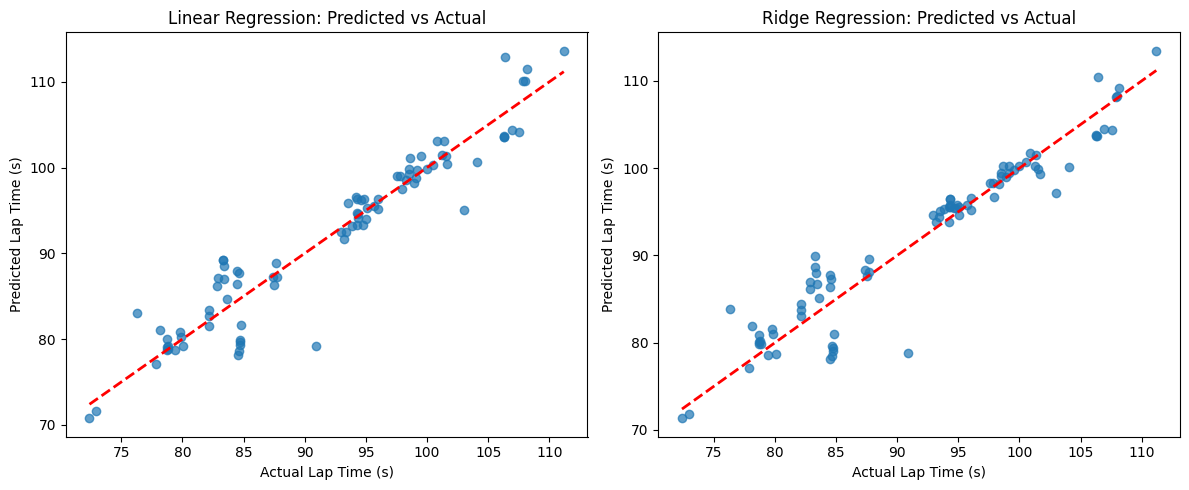


Overfitting Analysis:
Linear Regression gap: 0.094 seconds
Ridge Regression gap: 0.041 seconds


In [14]:
# TRAIN THE MODEL 
# I am using simpler regression models here because earlier tests with XGBoost and ANNs led to severe overfitting due to the lack of data 
# Of course with time there is the option of...drumroll...getting MORE data. But due to time constraints this is what we have to work with.

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

drivers = train_df['Driver'].copy()

# Encode categoricals
le_team = LabelEncoder()
le_race = LabelEncoder()
le_year=LabelEncoder()
le_driver = LabelEncoder()

train_df['TeamId_encoded'] = le_team.fit_transform(train_df['TeamId'])
train_df['Race_encoded'] = le_race.fit_transform(train_df['Race'])
train_df['Year_encoded'] = le_year.fit_transform(train_df['Year'])
# train_df['Driver_encoded'] = le_driver.fit_transform(train_df['Driver'])

X_init = train_df.drop(columns=['Driver', 'TeamId', 'Race', 'TotalSectorTime (s)','Year'])
X_init = X_init.fillna(0)

# Define categorical columns that should NOT be normalized
categorical_columns = ['Year_encoded','Is_Singapore', 'Downforce_Level', 'TeamId_encoded', 'Race_encoded','Rain']

# Identify columns to normalize
continuous_columns = [col for col in X_init.columns if col not in categorical_columns]

# Fit min-max scaler only on continuous columns
norm = StandardScaler().fit(X_init[continuous_columns])

# Create normalized dataset
X_normalized = X_init.copy()
X_normalized[continuous_columns] = norm.transform(X_init[continuous_columns])

print("FINAL TRAINING DATA\n")
X = X_normalized

X = pd.DataFrame(X, columns=X_init.columns)

# Reset indices to ensure alignment
X_reset = X.reset_index(drop=True)
y_reset = y.reset_index(drop=True) 
drivers_reset = drivers.reset_index(drop=True)

# Now create the boolean mask
valid_indices = y_reset.notna().squeeze()

# Apply the mask
X_clean = X_reset[valid_indices]
y_clean = y_reset[valid_indices]  
drivers_clean = drivers_reset[valid_indices]

print(f"Original shape: X{X_reset.shape}, y{y_reset.shape}")
print(f"After cleaning: X{X_clean.shape}, y{y_clean.shape}")

# Now use the cleaned data for train_test_split
X_train, X_test, y_train, y_test, drivers_train, drivers_test = train_test_split(
    X_clean, y_clean, drivers_clean, test_size=0.25, random_state=42
)

# print(" Y TRAIN : ",y_train)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

ridge_model = Ridge(alpha=5.0) # Increased regularisation to prevent overfitting (from a lot of trial runs...)
ridge_model.fit(X_train, y_train)

lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

ridge_train_pred = ridge_model.predict(X_train)
ridge_test_pred = ridge_model.predict(X_test)

# Debug the array shapes
print("Debug info:")
print(f"drivers_test shape: {drivers_test.shape}")
print(f"drivers_test type: {type(drivers_test)}")
print(f"lr_test_pred shape: {lr_test_pred.shape}")
print(f"lr_test_pred type: {type(lr_test_pred)}")
print(f"y_test shape: {y_test.shape}")
print(f"y_test type: {type(y_test)}")

# Check if they're all the same length
print(f"drivers_test length: {len(drivers_test)}")
print(f"lr_test_pred length: {len(lr_test_pred)}")
print(f"y_test length: {len(y_test)}")

# Evaluate models
print("\n=== LINEAR REGRESSION ===")
print(f"Training MAE: {mean_absolute_error(y_train, lr_train_pred):.3f} seconds")
print(f"Test MAE: {mean_absolute_error(y_test, lr_test_pred):.3f} seconds")
print(f"Test R²: {r2_score(y_test, lr_test_pred):.3f}")

print("\n=== RIDGE REGRESSION ===")
print(f"Training MAE: {mean_absolute_error(y_train, ridge_train_pred):.3f} seconds")
print(f"Test MAE: {mean_absolute_error(y_test, ridge_test_pred):.3f} seconds")
print(f"Test R²: {r2_score(y_test, ridge_test_pred):.3f}")

# === CROSS-VALIDATION ===
print("\n=== CROSS-VALIDATION RESULTS ===")

# 5-Fold Cross Validation
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Multiple metrics at once
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

lr_cv_results = cross_validate(lr_model, X_clean, y_clean.squeeze(), 
                               cv=cv_folds, scoring=scoring)
ridge_cv_results = cross_validate(ridge_model, X_clean, y_clean.squeeze(),
                                  cv=cv_folds, scoring=scoring)

for model_name, results in [("Linear", lr_cv_results), ("Ridge", ridge_cv_results)]:
    print(f"{model_name} Regression:")
    print(f"  CV MAE: {-results['test_neg_mean_absolute_error'].mean():.3f} ± {results['test_neg_mean_absolute_error'].std():.3f}")
    print(f"  CV RMSE: {np.sqrt(-results['test_neg_mean_squared_error'].mean()):.3f}")
    print(f"  CV R²: {results['test_r2'].mean():.3f} ± {results['test_r2'].std():.3f}")

print("X COLUMNS: ",X.columns)
print("COEFS : ",lr_model.coef_[0])
# Feature importance 
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features (Linear Regression):")
print(feature_importance.head(10))

# Convert everything to 1D numpy arrays
drivers_array = np.array(drivers_test).flatten()
pred_array = np.array(lr_test_pred).flatten()
actual_array = np.array(y_test).flatten()

test_results = pd.DataFrame({
    'Driver': drivers_array,
    'Predicted_LapTime': pred_array,
    'Actual_LapTime': actual_array
}).sort_values('Predicted_LapTime')

print("\nPredicted Fastest 3 Drivers (Test Set):")
print(test_results.head(3))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, lr_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Lap Time (s)')
plt.ylabel('Predicted Lap Time (s)')
plt.title('Linear Regression: Predicted vs Actual')

plt.subplot(1, 2, 2)
plt.scatter(y_test, ridge_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Lap Time (s)')
plt.ylabel('Predicted Lap Time (s)')
plt.title('Ridge Regression: Predicted vs Actual')

plt.tight_layout()
plt.show()

# Check overfitting
overfitting_gap_lr = mean_absolute_error(y_test, lr_test_pred) - mean_absolute_error(y_train, lr_train_pred)
overfitting_gap_ridge = mean_absolute_error(y_test, ridge_test_pred) - mean_absolute_error(y_train, ridge_train_pred)

print(f"\nOverfitting Analysis:")
print(f"Linear Regression gap: {overfitting_gap_lr:.3f} seconds")
print(f"Ridge Regression gap: {overfitting_gap_ridge:.3f} seconds")

In [15]:
X

,GridPosition,Grid_Gap_to_Pole,Quali_vs_Teammate,Best_Pace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Pressure,Rain,WindSpeed,TrackTemp,Is_Singapore,Downforce_Level,Safety_Car_Prob,VSC_Prob,Position_Flexibility,TeamId_encoded,Race_encoded,Year_encoded
0,-1.646874,-1.646874,-0.620889,0.612992,-1.702109,0.000000,1.428026,0.357536,0,-1.088908,0.149617,1,5,1.789770,-0.430767,1.579190,4,16,0
1,-1.473035,-1.473035,-1.707445,0.696064,-0.173650,0.448402,1.428026,0.357536,0,-1.088908,0.149617,1,5,1.789770,-0.430767,-0.003527,7,16,0
2,-0.951516,-0.951516,0.620889,0.685935,-0.360005,-0.448402,1.428026,0.357536,0,-1.088908,0.149617,1,5,1.789770,-0.430767,1.051618,4,16,0
3,-1.125356,-1.125356,0.155222,0.657502,-0.883169,-0.448402,1.428026,0.357536,0,-1.088908,0.149617,1,5,1.789770,-0.430767,-0.636614,5,16,0
4,-0.256159,-0.256159,-0.155222,0.697829,-0.141166,-0.896803,1.428026,0.357536,0,-1.088908,0.149617,1,5,1.789770,-0.430767,1.684704,2,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,1.134556,1.134556,0.620889,1.800710,0.358062,-0.672603,-0.609994,1.042537,0,-0.318712,-0.925542,0,1,-0.287887,0.097393,-0.320070,8,3,1
355,0.613038,0.613038,0.465667,1.832582,0.944485,1.121004,-0.609994,1.042537,0,-0.318712,-0.925542,0,1,-0.287887,0.097393,-0.847643,1,3,1
356,1.308396,1.308396,0.310445,1.823568,0.778645,0.000000,-0.609994,1.042537,0,-0.318712,-0.925542,0,1,-0.287887,0.097393,-0.109041,0,3,1
357,0.960717,0.960717,-0.310445,1.834254,0.975259,0.896803,-0.609994,1.042537,0,-0.318712,-0.925542,0,1,-0.287887,0.097393,0.629560,0,3,1


In [16]:
X.columns

Index(['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate',
       'Best_Pace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'WindSpeed',
       'TrackTemp', 'Is_Singapore', 'Downforce_Level', 'Safety_Car_Prob',
       'VSC_Prob', 'Position_Flexibility', 'TeamId_encoded', 'Race_encoded',
       'Year_encoded'],
      dtype='object')

In [17]:

#----------------CREATE PREDICTION DATASET-----------------

predict_df = pd.DataFrame()
predict_df['Abbreviation'] = ['PIA','NOR','HAM','LEC','RUS','ANT','LAW','HAD','SAI','ALB','VER','TSU','ALO','STR','BEA','OCO','BOR','HUL','GAS','COL']

# Create driver to team mapping (2025 season)
driver_to_team = {
    'PIA': 'mclaren',
    'NOR': 'mclaren', 
    'HAM': 'ferrari',       
    'LEC': 'ferrari',
    'RUS': 'mercedes',
    'ANT': 'mercedes',      
    'LAW': 'rb',           
    'HAD': 'rb',
    'SAI': 'williams',       
    'ALB': 'williams',
    'VER': 'red_bull',
    'TSU': 'red_bull',           
    'ALO': 'aston_martin',
    'STR': 'aston_martin',
    'BEA': 'haas',          
    'OCO': 'haas',
    'BOR': 'sauber',       
    'HUL': 'sauber',
    'GAS': 'alpine',
    'COL': 'alpine'    
}

predict_df['TeamId'] = predict_df['Abbreviation'].map(driver_to_team)

flex_map = {
    'PIA': 2.0, 
    'NOR': 3.0, 
    'VER': 0.0, 
    'TSU': 0.8, 
    'HAD': 1.0, 
    'LAW': 0.0, 
    'ALO': 2.2, 
    'STR': -1.6, 
    'OCO': -2.2, 
    'BEA': -1.6, 
    'RUS': -1.2, 
    'ANT': 0.0, 
    'GAS': -0.2, 
    'COL': 1.2, 
    'HAM': -1.2, 
    'LEC': 3.2, 
    'ALB': -5.2, 
    'SAI': 1.0, 
    'BOR': -0.2, 
    'HUL': -0.6
}
predict_df['Position_Flexibility'] = predict_df['Abbreviation'].map(flex_map)

grid_positions = {
    'RUS': 1.0,
    'VER': 2.0, 
    'PIA': 3.0,
    'ANT': 4.0,
    'NOR': 5.0,
    'HAM': 6.0,       
    'LEC': 7.0,          
    'HAD': 8.0,
    'BEA': 9.0,    
    'ALO': 10.0,
    'HUL': 11.0,            
    'ALB': 12.0,
    'SAI': 13.0,
    'LAW': 14.0,          
    'TSU': 15.0,
    'BOR': 16.0,       
    'STR': 17.0,
    'COL': 18.0,
    'OCO': 19.0,  
    'GAS': 20.0
}

predict_df['GridPosition'] = predict_df['Abbreviation'].map(grid_positions)
predict_df['Grid_Gap_to_Pole'] = predict_df['GridPosition'] - predict_df['GridPosition'].min()
predict_df['Quali_vs_Teammate'] = predict_df.groupby('TeamId')['GridPosition'].transform(lambda x: x - x.mean())

predict_df['Race'] = 'Singapore'
predict_df['Year'] = 2025

safety_car_map={
            'Monaco': 43,
            'Canada': 83,
            'Silverstone': 88,
            'Imola': 75,
            'Hungary': 25,
            'Australia': 50,
            'Bahrain': 63,
            'Austria': 38,
            'Netherlands': 50,
            'Spain': 38,
            'Japan': 67,
            'Saudi Arabia': 100,
            'Baku': 57,
            'Belgium': 63,
            'Miami': 67,
            'Monza': 50,
            'Singapore': 83,
            'China': 75
        }
predict_df['Safety_Car_Prob'] = predict_df['Race'].map(safety_car_map)
        
virtual_safety_car_map={
    'Monaco': 29,
    'Canada': 50,
    'Silverstone': 13,
    'Imola': 25,
    'Hungary': 25,
    'Australia': 67,
    'Bahrain': 50,
    'Austria': 50,
    'Netherlands': 50,
    'Spain': 25,
    'Japan': 50,
    'Saudi Arabia': 50,
    'Baku': 43,
    'Belgium': 0,
    'Miami': 67,
    'Monza': 38,
    'Singapore': 33,
    'China': 75
}
predict_df['VSC_Prob'] = predict_df['Race'].map(virtual_safety_car_map)

# Encode categorical variables using the same encoders from training
predict_df['Race_encoded'] = le_race.transform(predict_df['Race'])
predict_df['TeamId_encoded'] = le_team.transform(predict_df['TeamId'])
predict_df['Year_encoded'] = le_year.transform(predict_df['Year'])
# predict_df['Driver_encoded'] = le_driver.transform(predict_df['Abbreviation'])

predict_df['Is_Singapore'] = 1

# Add Downforce Level (Singapore is high downforce = 5)
predict_df['Downforce_Level'] = 5

# Get practice pace data
best_race_pace = get_best_race_pace(2025, 'Singapore')
best_race_pace.drop(columns=['IsPersonalBest','Session'], inplace=True)
pace_mapping = best_race_pace.set_index('Driver')['LapTime (s)']
predict_df['Best_Pace_seconds'] = predict_df['Abbreviation'].map(pace_mapping)
        
predict_df['Practice_Gap_to_Fastest'] = predict_df['Best_Pace_seconds'] - predict_df['Best_Pace_seconds'].min()
predict_df['Practice_vs_Quali_Rank'] = predict_df['Best_Pace_seconds'].rank() - predict_df['GridPosition']
predict_df['Quali_vs_Teammate'] = predict_df['Quali_vs_Teammate'].fillna(0)

# Weather data (predicted for race day)
predict_df['Rain'] = 0
predict_df['AirTemp'] = 30.000000
predict_df['TrackTemp'] = 33.000000
predict_df['Pressure'] = 1013.000000
predict_df['WindSpeed'] = 8.000000


# Drop original categorical columns (keep only encoded versions)
predict_df.drop(columns=['TeamId', 'Race','Year'], inplace=True)

# Rename Driver column to match training data
predict_df.rename(columns={'Abbreviation': 'Driver'}, inplace=True)

# Create final prediction features (same structure as training)
X_predict = predict_df.drop(columns=['Driver'])
X_predict = X_predict.fillna(0)

# CRITICAL FIX: Reorder columns to match EXACTLY what the training data had
# Get the exact column order from the training data
training_columns = X_clean.columns.tolist()
print("Training columns order:", training_columns)

# Reorder prediction data to match training data exactly
X_predict = X_predict[training_columns]

print("Prediction columns order:", X_predict.columns.tolist())
print("Columns match:", list(X_predict.columns) == training_columns)

# Apply the same normalization as training data
categorical_columns = ['Year_encoded', 'Is_Singapore', 'Downforce_Level', 'TeamId_encoded', 'Race_encoded', 'Rain']
continuous_columns = [col for col in X_predict.columns if col not in categorical_columns]

print("Continuous columns for normalization:", continuous_columns)

# Normalize only continuous columns using the same scaler fitted on training data
X_predict_normalized = X_predict.copy()
X_predict_normalized[continuous_columns] = norm.transform(X_predict[continuous_columns])

print("Prediction dataset shape:", X_predict_normalized.shape)
print("Training dataset shape:", X.shape)

Training columns order: ['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Best_Pace_seconds', 'Practice_Gap_to_Fastest', 'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'WindSpeed', 'TrackTemp', 'Is_Singapore', 'Downforce_Level', 'Safety_Car_Prob', 'VSC_Prob', 'Position_Flexibility', 'TeamId_encoded', 'Race_encoded', 'Year_encoded']
Prediction columns order: ['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Best_Pace_seconds', 'Practice_Gap_to_Fastest', 'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'WindSpeed', 'TrackTemp', 'Is_Singapore', 'Downforce_Level', 'Safety_Car_Prob', 'VSC_Prob', 'Position_Flexibility', 'TeamId_encoded', 'Race_encoded', 'Year_encoded']
Columns match: True
Continuous columns for normalization: ['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Best_Pace_seconds', 'Practice_Gap_to_Fastest', 'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'WindSpeed', 'TrackTemp', 'Safety_Car_Prob', 'VSC_Prob', 'Position_Flexibility'

In [18]:
X_predict_normalized

,GridPosition,Grid_Gap_to_Pole,Quali_vs_Teammate,Best_Pace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Pressure,Rain,WindSpeed,TrackTemp,Is_Singapore,Downforce_Level,Safety_Car_Prob,VSC_Prob,Position_Flexibility,TeamId_encoded,Race_encoded,Year_encoded
0,-1.299195,-1.299195,-0.310445,0.661218,-1.673044,-0.224201,1.271456,0.617878,0,8.739942,-0.20871,1,5,0.968371,-0.430767,1.051618,4,16,1
1,-0.951516,-0.951516,0.310445,0.667909,-1.549947,-0.112100,1.271456,0.617878,0,8.739942,-0.20871,1,5,0.968371,-0.430767,1.579190,4,16,1
2,-0.777677,-0.777677,-0.155222,0.697829,-0.999428,0.448402,1.271456,0.617878,0,8.739942,-0.20871,1,5,0.968371,-0.430767,-0.636614,2,16,1
3,-0.603838,-0.603838,0.155222,0.706378,-0.842137,0.672603,1.271456,0.617878,0,8.739942,-0.20871,1,5,0.968371,-0.430767,1.684704,2,16,1
4,-1.646874,-1.646874,-0.465667,0.664192,-1.618334,0.448402,1.271456,0.617878,0,8.739942,-0.20871,1,5,0.968371,-0.430767,-0.636614,5,16,1
5,-1.125356,-1.125356,0.465667,0.667909,-1.549947,0.112100,1.271456,0.617878,0,8.739942,-0.20871,1,5,0.968371,-0.430767,-0.003527,5,16,1
6,0.613038,0.613038,0.931334,0.874565,2.252394,1.345205,1.271456,0.617878,0,8.739942,-0.20871,1,5,0.968371,-0.430767,-0.003527,6,16,1
7,-0.429998,-0.429998,-0.931334,0.691325,-1.119106,-0.224201,1.271456,0.617878,0,8.739942,-0.20871,1,5,0.968371,-0.430767,0.524045,6,16,1
8,0.439199,0.439199,0.155222,0.682312,-1.284945,-1.569406,1.271456,0.617878,0,8.739942,-0.20871,1,5,0.968371,-0.430767,0.524045,9,16,1
9,0.265359,0.265359,-0.155222,0.707958,-0.813072,-0.224201,1.271456,0.617878,0,8.739942,-0.20871,1,5,0.968371,-0.430767,-2.746903,9,16,1


In [19]:
#Make Predictions
       
# Adjust grid position importance for Singapore specifically
print("Adjusting grid position importance for Singapore...")
X_predict_normalized['GridPosition'] *= 1.5
X_predict_normalized['Grid_Gap_to_Pole'] *= 1.5

predicted_lap_times = ridge_model.predict(X_predict_normalized)

print("PREDICTIONS")
# print(predicted_lap_times)

results_df = pd.DataFrame({
    'Driver': predict_df['Driver'],
    'Predicted_LapTime': predicted_lap_times.flatten()
}).sort_values('Predicted_LapTime')

# Get top 3 fastest 
print("\nPREDICTED 2025 SINGAPORE PODIUM")
print("===============================")
print(f"Driver \t\t Average Lap Time (s)")
print(f"🥇 P1: {results_df.iloc[0]['Driver']} \t {results_df.iloc[0]['Predicted_LapTime']}s")
print(f"🥈 P2: {results_df.iloc[1]['Driver']} \t {results_df.iloc[1]['Predicted_LapTime']}s") 
print(f"🥉 P3: {results_df.iloc[2]['Driver']} \t {results_df.iloc[2]['Predicted_LapTime']}s")

print("\nFull Results:")
results_df.reset_index(drop=True, inplace=True)
print(results_df.head(20))

Adjusting grid position importance for Singapore...
PREDICTIONS

PREDICTED 2025 SINGAPORE PODIUM
Driver 		 Average Lap Time (s)
🥇 P1: RUS 	 124.15542856686092s
🥈 P2: PIA 	 124.32963155649088s
🥉 P3: VER 	 124.76634053000544s

Full Results:
   Driver  Predicted_LapTime
0     RUS         124.155429
1     PIA         124.329632
2     VER         124.766341
3     ANT         124.936092
4     NOR         125.086558
5     HAM         125.407224
6     LEC         125.766541
7     LAW         126.243674
8     HAD         126.561356
9     ALO         127.488472
10    BEA         127.602225
11    HUL         127.733188
12    SAI         127.964576
13    TSU         128.119668
14    ALB         128.406562
15    STR         128.519824
16    GAS         128.949070
17    BOR         129.189293
18    COL         129.203600
19    OCO         129.248415


## Extra Analysis

In [20]:
coefs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_.flatten(),
    'Abs_Coefficient': abs(lr_model.coef_.flatten())
}).sort_values('Abs_Coefficient', ascending=False)

print(coefs.head(20))

                    Feature  Coefficient  Abs_Coefficient
3         Best_Pace_seconds     9.594549         9.594549
8                      Rain     9.046281         9.046281
10                TrackTemp    -6.371848         6.371848
6                   AirTemp     4.657374         4.657374
18             Year_encoded     3.138602         3.138602
11             Is_Singapore    -3.138602         3.138602
4   Practice_Gap_to_Fastest    -2.724743         2.724743
9                 WindSpeed     2.359369         2.359369
12          Downforce_Level     2.306015         2.306015
5    Practice_vs_Quali_Rank     1.581543         1.581543
1          Grid_Gap_to_Pole     1.371192         1.371192
0              GridPosition     1.371192         1.371192
13          Safety_Car_Prob    -0.715923         0.715923
14                 VSC_Prob    -0.569859         0.569859
17             Race_encoded     0.402150         0.402150
2         Quali_vs_Teammate    -0.322747         0.322747
7             

In [21]:
# Check practice pace data for all drivers
print("=== PRACTICE PACE ANALYSIS ===")
practice_check = predict_df[['Driver', 'GridPosition']].copy()
practice_check['Best_Pace_seconds'] = X_predict['Best_Pace_seconds']
practice_check = practice_check.sort_values('Best_Pace_seconds')
print(practice_check)
print(f"\nRussell's practice pace: {practice_check[practice_check['Driver']=='RUS']['Best_Pace_seconds'].values[0]:.3f}s")
print(f"Fastest practice pace: {practice_check['Best_Pace_seconds'].min():.3f}s")
print(f"Practice pace range: {practice_check['Best_Pace_seconds'].min():.3f}s - {practice_check['Best_Pace_seconds'].max():.3f}s")

=== PRACTICE PACE ANALYSIS ===
   Driver  GridPosition  Best_Pace_seconds
10    VER           2.0             90.148
0     PIA           3.0             90.165
4     RUS           1.0             90.197
1     NOR           5.0             90.237
5     ANT           4.0             90.237
8     SAI          13.0             90.392
7     HAD           8.0             90.489
2     HAM           6.0             90.559
17    HUL          11.0             90.637
3     LEC           7.0             90.651
9     ALB          12.0             90.668
16    BOR          16.0             90.697
15    OCO          19.0             90.784
14    BEA           9.0             90.799
12    ALO          10.0             90.877
19    COL          18.0             91.047
13    STR          17.0             91.222
11    TSU          15.0             91.440
18    GAS          20.0             91.643
6     LAW          14.0             92.461

Russell's practice pace: 90.197s
Fastest practice pace: 90.148s
P